In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from itertools import combinations
from numpy import array,array_equal
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import plot_tree
from matplotlib.pylab import rcParams
from sklearn.metrics import accuracy_score 
import pickle
#importing our cancer dataset
dataset = pd.read_csv("c:/users/fadic/anaconda3/Library/lib/Untitled Folder/breast-cancer-wisconsin-data.csv")


In [2]:
dataset.head()

,ID,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [3]:
# Convert the dictionary into DataFrame
dataset_pd = pd.DataFrame(dataset)
# Before renaming the columns
print(dataset_pd)
 
dataset_pd.rename(columns = {'class':'diag'}, inplace = True)
 
# After renaming the columns
print("\nAfter modifying first column:\n", dataset_pd.columns)

          ID  clump_thickness  uniformity_cell_size  uniformity_cell_shape  \
0    1000025                5                     1                      1   
1    1002945                5                     4                      4   
2    1015425                3                     1                      1   
3    1016277                6                     8                      8   
4    1017023                4                     1                      1   
..       ...              ...                   ...                    ...   
694   776715                3                     1                      1   
695   841769                2                     1                      1   
696   888820                5                    10                     10   
697   897471                4                     8                      6   
698   897471                4                     8                      8   

     marginal_adhesion  single_epi_cell_size bare_nuclei  bland

In [4]:
print("Cancer data set dimensions : {}".format(dataset.shape))

Cancer data set dimensions : (699, 11)


In [5]:
#need to convert the 2 and 4 to 0  and 1 for the code to work.
dataset['diag'].replace([2, 4], 
                         [0, 1], inplace=True)

In [6]:
#check to see if it worked.
dataset.head()

,ID,clump_thickness,uniformity_cell_size,uniformity_cell_shape,marginal_adhesion,single_epi_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,diag
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [7]:
#this is based on the table from the logistic regression code displayed.
data=dataset.drop(columns=['ID' , 'clump_thickness' , 'mitoses' , 'bare_nuclei' , 'single_epi_cell_size'])

In [8]:


data
X_train = data.iloc[:,:-1]
y_train = data.diag

X_test = data.iloc[:,:-1]
y_test = data.diag
#X = data.iloc[:, 1:5].values
#Y = data.iloc[:, 5].values

In [9]:
# Create a random forest classifier
clf = RandomForestClassifier(random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(X_train.columns, clf.feature_importances_):
    print(feature)

('uniformity_cell_size', 0.31361378117662636)
('uniformity_cell_shape', 0.3371952764609277)
('marginal_adhesion', 0.04580282152755143)
('bland_chromatin', 0.15759749041565027)
('normal_nucleoli', 0.14579063041924425)


In [10]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
sfm = SelectFromModel(clf, threshold=0.002)

# Train the selector
sfm.fit(X_train, y_train)

# Print the names of the most important features
print(len(sfm.get_support(indices=True)), "features selected")
for feature_list_index in sfm.get_support(indices=True):
    print(X_train.columns[feature_list_index], clf.feature_importances_[feature_list_index])

5 features selected
uniformity_cell_size 0.31361378117662636
uniformity_cell_shape 0.3371952764609277
marginal_adhesion 0.04580282152755143
bland_chromatin 0.15759749041565027
normal_nucleoli 0.14579063041924425


In [11]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [12]:
def confusio_matrix(y_test, y_predicted):
  cm = confusion_matrix(y_test, y_predicted)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Matrice de confusion')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

In [13]:
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, max_depth = 4, seed=1729)
m2_xgb.fit(X_important_train, y_train, eval_metric="auc", verbose = False, eval_set=[(X_important_test, y_test)])

C:\Users\fadic\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=110, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

In [14]:
y_predicted = m2_xgb.predict(X_important_test)

In [15]:
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,

In [16]:
print(len(y_test))

699


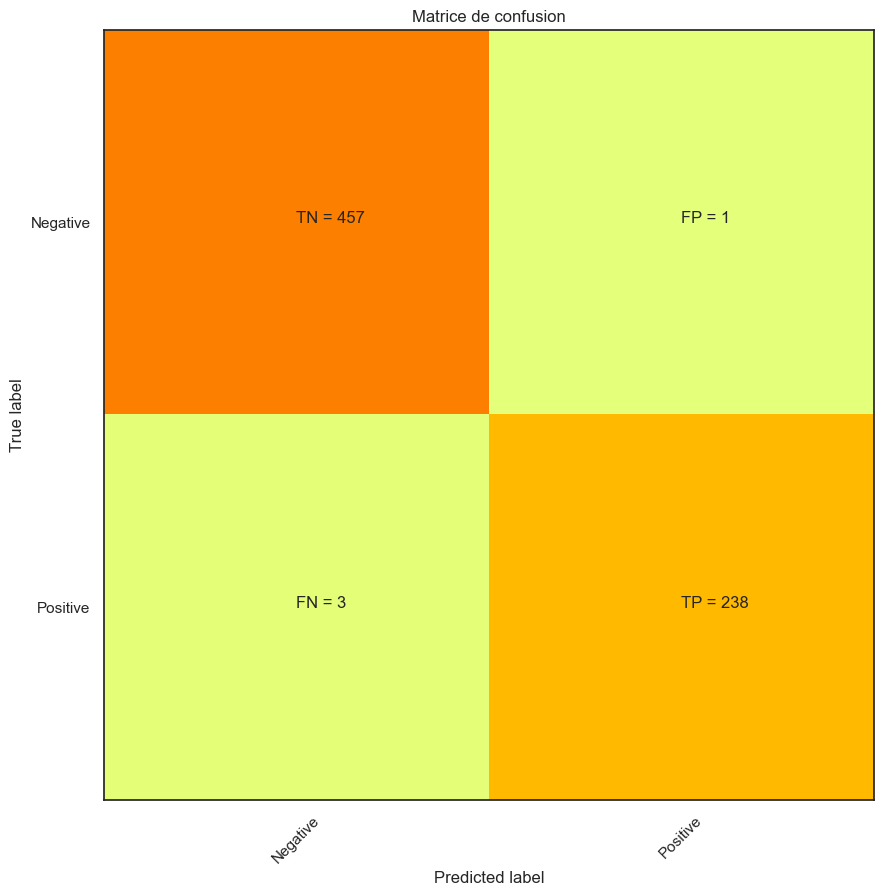

In [17]:
confusio_matrix(y_test,y_predicted)

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)
c = print(cm[0, 0] + cm[1, 1])

695


In [20]:
y_predicted = m2_xgb.predict(X_test)  
score = accuracy_score(y_test, y_predicted)  
print(score) 

0.994277539341917


In [21]:
import pickle
with open('file_cancer.pkl','wb') as file:
    pickle.dump(m2_xgb,file)